In [3]:
import random
random.seed(0)

import numpy as np
np.random.seed(0)

import tensorflow as tf
tf.random.set_seed(0)

In [28]:
import os
import json
from zipfile import ZipFile
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout, BatchNormalization
from keras.models import Sequential
from tensorflow.keras.callbacks import  ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard

In [23]:
#kaggle_credentials = json.load(open('kaggle.json'))


In [24]:
#os.environ['KAGGLE_USERNAME'] = kaggle_credentials['username']
#os.environ['KAGGLE_KEY'] = kaggle_credentials['key']

In [6]:
!kaggle datasets download -d abdallahalidev/plantvillage-dataset

Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0
 99%|██████████████████████████████████████▋| 2.02G/2.04G [00:12<00:00, 216MB/s]
100%|███████████████████████████████████████| 2.04G/2.04G [00:12<00:00, 180MB/s]


In [7]:
!ls

plantvillage-dataset.zip


In [8]:
with ZipFile('plantvillage-dataset.zip','r') as zip_ref:
  zip_ref.extractall()

In [9]:
from posix import listdir
print(os.listdir('plantvillage dataset'))

print(len(os.listdir('plantvillage dataset/segmented')))
print(os.listdir('plantvillage dataset/segmented')[:5])

print(len(os.listdir('plantvillage dataset/color')))
print(os.listdir('plantvillage dataset/color')[:5])

print(len(os.listdir('plantvillage dataset/grayscale')))
print(os.listdir('plantvillage dataset/grayscale')[:5])


['segmented', 'grayscale', 'color']
38
['Potato___Early_blight', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Tomato___Late_blight', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Orange___Haunglongbing_(Citrus_greening)']
38
['Potato___Early_blight', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Tomato___Late_blight', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Orange___Haunglongbing_(Citrus_greening)']
38
['Potato___Early_blight', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Tomato___Late_blight', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Orange___Haunglongbing_(Citrus_greening)']


In [10]:
print(len(os.listdir('plantvillage dataset/color/Peach___healthy')))
print(os.listdir('plantvillage dataset/color/Peach___healthy')[:5])

360
['d5cef93b-b589-4bbc-a383-c717a80bd915___Rutg._HL 2452.JPG', '4fc5eb54-978b-40e9-8054-84b44937bc89___Rutg._HL 2453.JPG', '4ac10c27-25ba-4612-9351-13491106abf4___Rutg._HL 3741.JPG', '7cfd0ac5-2c8a-4a59-ab0f-822e77d96060___Rutg._HL 3632.JPG', '7b7c9e4f-3379-4a0a-9c94-5d9458653707___Rutg._HL 2451.JPG']


In [29]:
base_dir = 'plantvillage dataset/color'

(256, 256, 3)


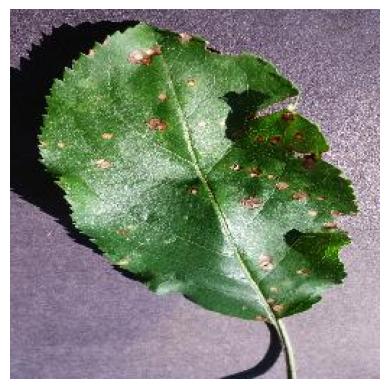

In [30]:
image_path = 'plantvillage dataset/color/Apple___Black_rot/02186b4f-a9e1-4d19-ae3d-6cfb0f4b106a___JR_FrgE.S 2828.JPG'

img = mpimg.imread(image_path)

print(img.shape)

plt.imshow(img)
plt.axis('off')
plt.show()

In [31]:
img_size = 224
batch_size = 32

In [32]:
data_gen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split = 0.2 #use 20% of data for validation
)

In [33]:
train_generator = data_gen.flow_from_directory(
    base_dir,
    target_size = (img_size, img_size),
    batch_size = batch_size,
    subset = 'training',
    class_mode = 'categorical'
)

Found 43456 images belonging to 38 classes.


In [34]:
val_generator = data_gen.flow_from_directory(
    base_dir,
    target_size = (img_size, img_size),
    batch_size = batch_size,
    subset = 'validation',
    class_mode = 'categorical'
)

Found 10849 images belonging to 38 classes.


In [35]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

# Second Convolutional Block
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

# Flattening the output
model.add(Flatten())

# Fully Connected Layers
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(38, activation='softmax'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [37]:
# Define callbacks
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1)
log_dir = os.path.join("logs", "fit")
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks = [checkpoint, early_stopping, reduce_lr, tensorboard]

In [38]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    47,776,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 38)             │         9,766 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,806,566 (182.37 MB)

 Trainable params: 47,805,862 (182.36 MB)

 Non-trainable params: 704 (2.75 KB)

In [41]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [42]:
history = model.fit(train_generator,
          steps_per_epoch = train_generator.samples // batch_size,
          epochs=30,
          validation_data = val_generator,
          validation_steps = val_generator.samples// batch_size,
          callbacks=callbacks
)

Epoch 1/30
   2/1358 ━━━━━━━━━━━━━━━━━━━━ 1:36 71ms/step - accuracy: 0.0469 - loss: 5.0791      

W0000 00:00:1718373359.525272     184 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.4458 - loss: 2.1343

W0000 00:00:1718373819.706852     182 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.59467, saving model to best_model.keras
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 593s 430ms/step - accuracy: 0.4459 - loss: 2.1340 - val_accuracy: 0.5947 - val_loss: 1.3516 - learning_rate: 0.0010
Epoch 2/30

Epoch 2: val_accuracy did not improve from 0.59467
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 2.2676 - learning_rate: 0.0010
Epoch 3/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.6882 - loss: 1.0333
Epoch 3: val_accuracy did not improve from 0.59467
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 582s 427ms/step - accuracy: 0.6882 - loss: 1.0332 - val_accuracy: 0.5556 - val_loss: 1.4134 - learning_rate: 0.0010
Epoch 4/30

Epoch 4: val_accuracy improved from 0.59467 to 1.00000, saving model to best_model.keras
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 1.0546 - learning_rate: 0.0010
Epoch 5

KeyboardInterrupt: 

In [ ]:
print("Evaluation model...")
val_loss, val_accuracy = model.evaluate(val_generator, steps=val_generator.samples//batch_size)
print(f"validation Accuracy: {val_accuracy * 100:.2f}%")

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracu')
plt.xlabel("Epoch")
plt.legend(['Train','Test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel("Epoch")
plt.legend(['Train','Test'], loc='upper left')
plt.show()

In [ ]:
def load_and_preprocess_image(image_path, target_size=(224,224)):
  #Load the image
  img = Image.open(image_path)
  #resize
  img = img.resize(target_size)
  #convert img to numpy array
  img_array = np.array(img)
  #Add batch dimension
  img_array = np.expand_dims(img_array, axis=0)
  #scale the image values to [0,1]
  img_array = img_array.astype('float32')/255.

  return img_array



def predict_image_class(model,image_path,class_indices):
  preprocessed_img = load_and_preprocess_image(image_path)
  predictions = model.predict(preprocessed_img)
  predicted_class_index = np.argmax(predictions, axis=1)[0]
  predicted_class_name = class_indices[predicted_class_index]
  return predicted_class_name

In [ ]:
class_indices = {v: k for k , v in train_generator.class_indices.items()}

In [ ]:
class_indices

In [ ]:
json.dump(class_indices, open('class_indices.json','w'))

In [ ]:
image_path = '/content/plantvillage dataset/color/Strawberry___healthy/03fe6806-ca61-46c1-8889-45e40228c168___RS_HL 4632.JPG'
predicted_class_name = predict_image_class(model,image_path, class_indices)

print("Predicted Class name:", predicted_class_name)

In [ ]:
model.save('plant_disease_prediction_model.h5')